In [1]:
from pathlib import Path
import keypoint_moseq as kpms

In [6]:
DATA_DIR = Path.home() / "Data" / "behav-analysis-course" / "mouse-EPM"
behav_deriv_dir = DATA_DIR / "derivatives" / "behav"
# Create keypoint-moseq project dir
kpms_project_dir = behav_deriv_dir / "software-kpms_project"
kpms_project_dir.mkdir(exist_ok=True)

# SLEAP predictions
sleap_predictions_dir = behav_deriv_dir / "software-SLEAP_project" / "predictions"
video1_sleap_preds_file = sleap_predictions_dir / "video-1.predictions.analysis.h5"
video2_sleap_preds_file = sleap_predictions_dir / "video-2.predictions.analysis.h5"

# DeepLabCut predictions
dlc_predictions_dir = behav_deriv_dir / "software-DLC_predictions"
video1_dlc_preds_file = dlc_predictions_dir / "sub-01_ses-01_task-EPM_time-165049_video_DLC_resnet50_MouseTopDownSep13shuffle1_340000_filtered.h5"
video2_dlc_preds_file = dlc_predictions_dir / "sub-02_ses-01_task-EPM_time-185651_video_DLC_resnet50_MouseTopDownSep13shuffle1_340000_filtered.h5"

# Videos
video_dir = DATA_DIR / "rawdata" / "videos"
assert video_dir.exists()

# Frames (used as background for plotting)
video1_frame_file = dlc_predictions_dir / "sub-01_ses-01_task-EPM_time-170049_frame.png"
video2_frame_file = dlc_predictions_dir / "sub-02_ses-01_task-EPM_time-190651_frame.png"

In [7]:
kpms.setup_project(kpms_project_dir, sleap_file=video1_sleap_preds_file, overwrite=True)

In [8]:
kpms.update_config(
    kpms_project_dir.as_posix(),
    video_dir=video_dir.as_posix(),
    anterior_bodyparts=["snout", "left_ear", "right_ear"],
    posterior_bodyparts=["tail_base"],
    use_bodyparts=[
        "snout",
        "left_ear",
        "right_ear",
        "centre",
        "tail_base",
    ],
)

In [9]:
config = kpms.load_config(kpms_project_dir)

In [10]:
coordinates, confidences, bodyparts = kpms.load_keypoints(
    video1_sleap_preds_file.as_posix(),
    "sleap"
)


Loading keypoints:   0%|                          | 0/1 [00:00<?, ?it/s]

Loading keypoints: 100%|██████████████████| 1/1 [00:00<00:00, 15.05it/s]


In [11]:
# format data for modeling
data, metadata = kpms.format_data(coordinates, confidences, **config)

Loading sample frames: 100%|████████████| 30/30 [00:01<00:00, 17.86it/s]


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
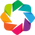

BokehModel(combine_events=True, render_bundle={'docs_json': {'f4a4201b-9b45-435a-9f00-3e400e866bc8': {'version…

In [13]:
kpms.noise_calibration(kpms_project_dir, coordinates, confidences, **config)

>=90.0% of variance exlained by 4 components.


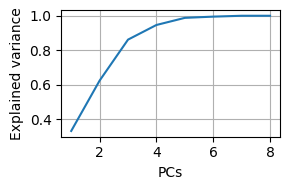

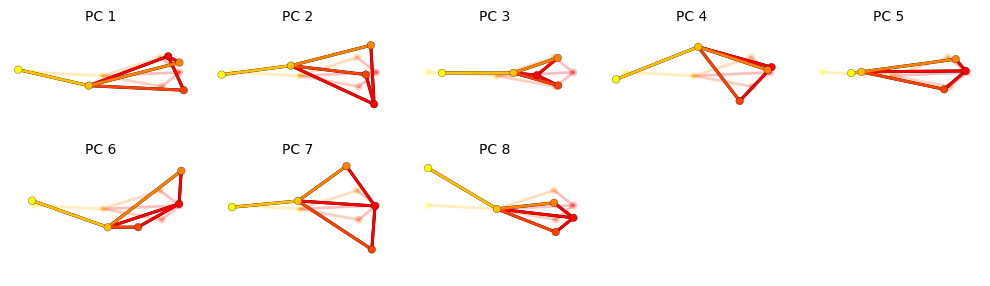

In [14]:
pca = kpms.fit_pca(**data, **config)
kpms.save_pca(pca, kpms_project_dir)

kpms.print_dims_to_explain_variance(pca, 0.9)
kpms.plot_scree(pca, project_dir=kpms_project_dir)
kpms.plot_pcs(pca, project_dir=kpms_project_dir, **config)

# use the following to load an already fit model
# pca = kpms.load_pca(project_dir)

In [19]:
kpms.update_config(kpms_project_dir, latent_dim=3) # ~90% explained variance but we are limited by num_keypoints
config = kpms.load_config(kpms_project_dir)

In [20]:
# initialize the model
model = kpms.init_model(data, pca=pca, **config)

# optionally modify kappa
# model = kpms.update_hypparams(model, kappa=NUMBER)

Outputs will be saved to /Users/nsirmpilatze/Data/behav-analysis-
course/mouse-EPM/derivatives/behav/software-
kpms_project/2024_08_16-15_27_00


 49%|█████████████████▏                 | 25/51 [00:05<00:03,  7.33it/s]

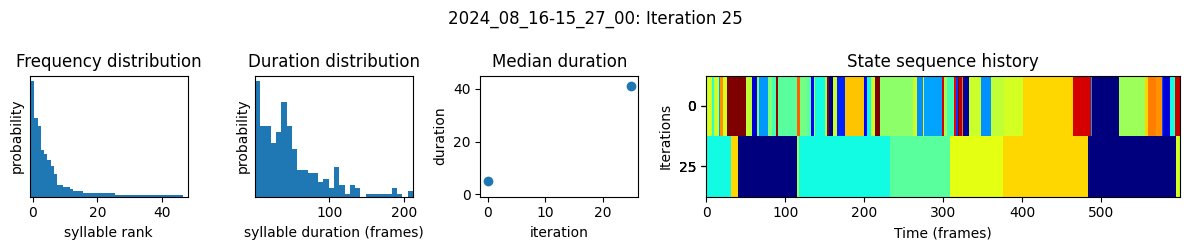

 98%|██████████████████████████████████▎| 50/51 [00:09<00:00,  7.18it/s]

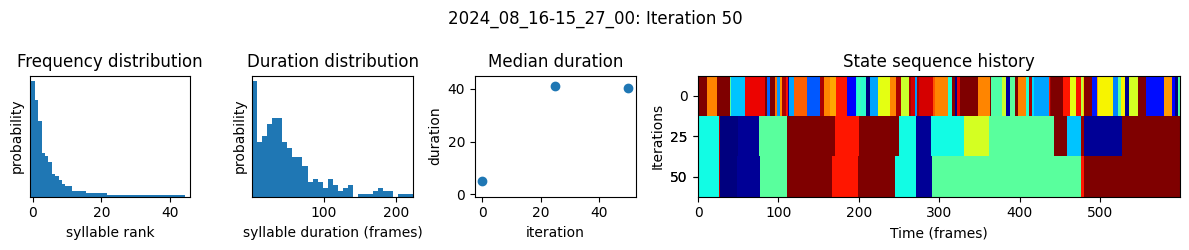

100%|███████████████████████████████████| 51/51 [00:09<00:00,  5.18it/s]


In [21]:
num_ar_iters = 50

model, model_name = kpms.fit_model(
    model, data, metadata, kpms_project_dir,
    ar_only=True, num_iters=num_ar_iters)

Outputs will be saved to /Users/nsirmpilatze/Data/behav-analysis-
course/mouse-EPM/derivatives/behav/software-
kpms_project/2024_08_16-15_27_00


  5%|█▋                                | 25/501 [00:41<03:17,  2.41it/s]

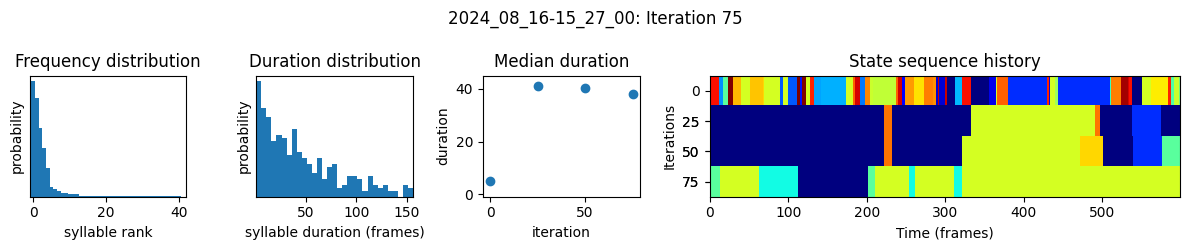

 10%|███▍                              | 50/501 [00:52<03:10,  2.37it/s]

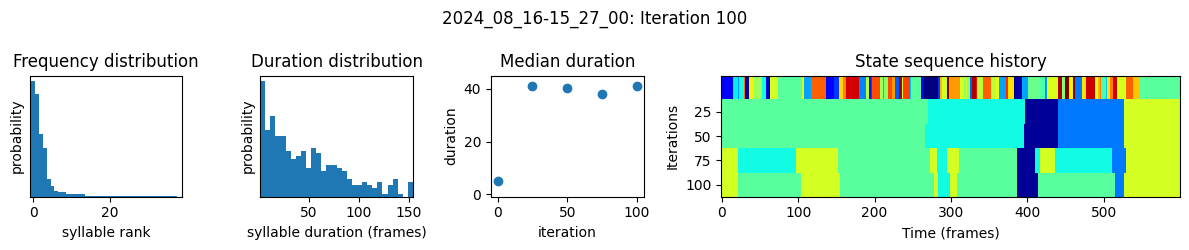

 15%|█████                             | 75/501 [01:03<03:01,  2.35it/s]

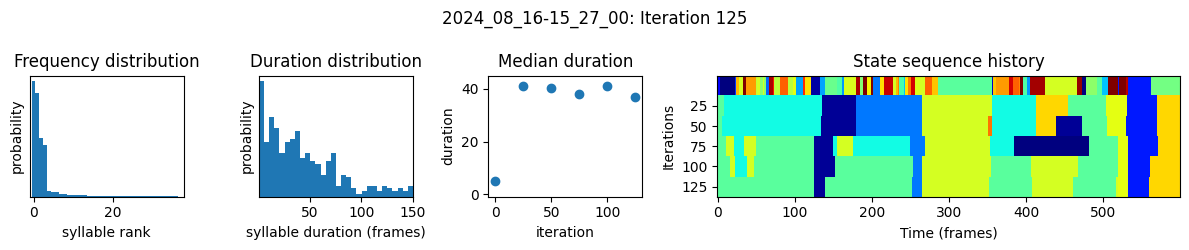

 20%|██████▌                          | 100/501 [01:14<02:43,  2.46it/s]

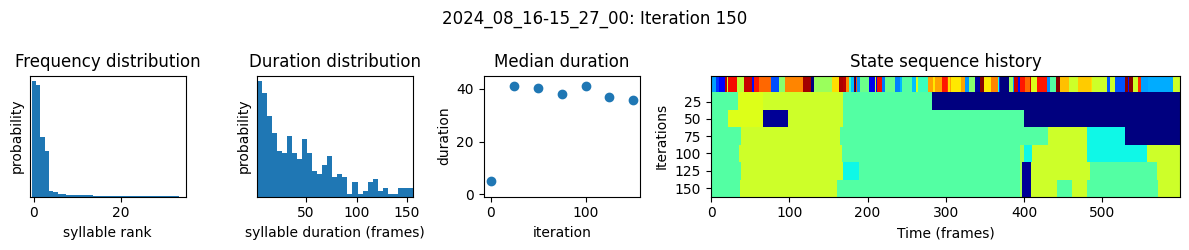

 25%|████████▏                        | 125/501 [01:25<02:39,  2.36it/s]

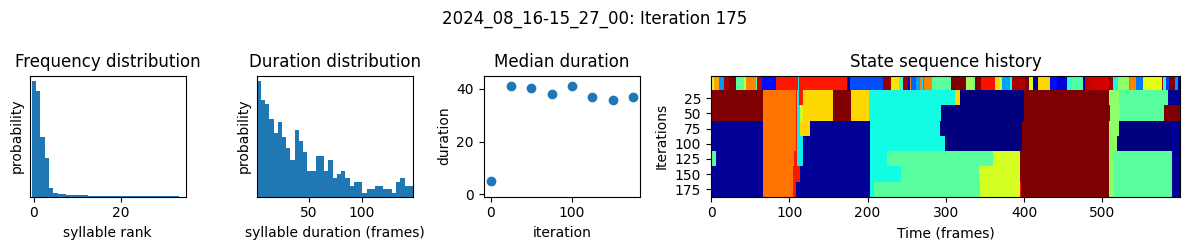

 30%|█████████▉                       | 150/501 [01:36<02:31,  2.32it/s]

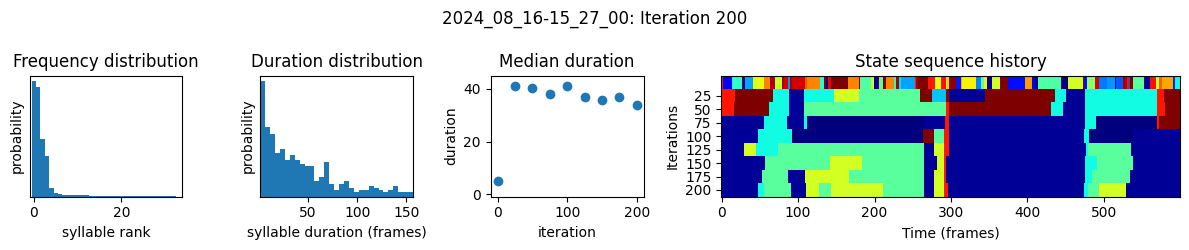

 35%|███████████▌                     | 175/501 [01:48<02:34,  2.11it/s]

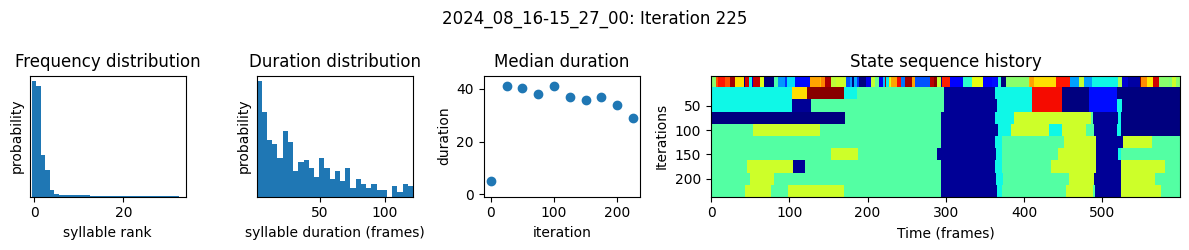

 40%|█████████████▏                   | 200/501 [01:58<02:05,  2.40it/s]

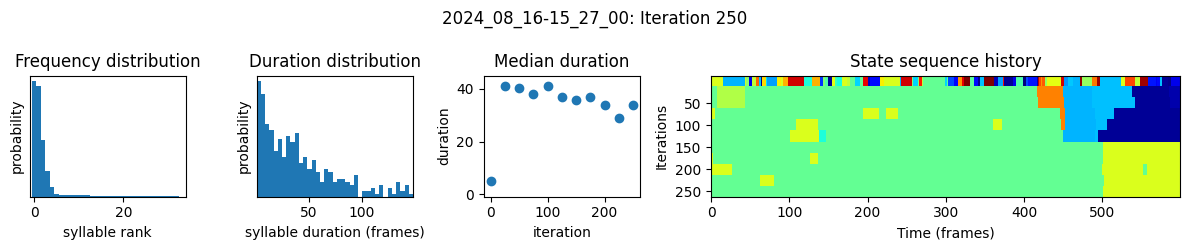

 45%|██████████████▊                  | 225/501 [02:09<01:53,  2.42it/s]

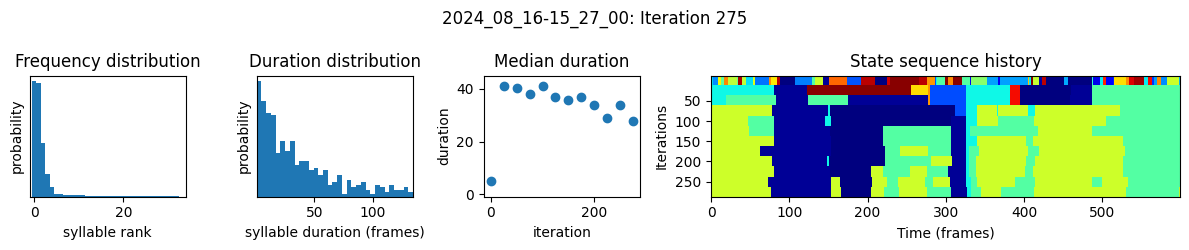

 50%|████████████████▍                | 250/501 [02:20<01:45,  2.38it/s]

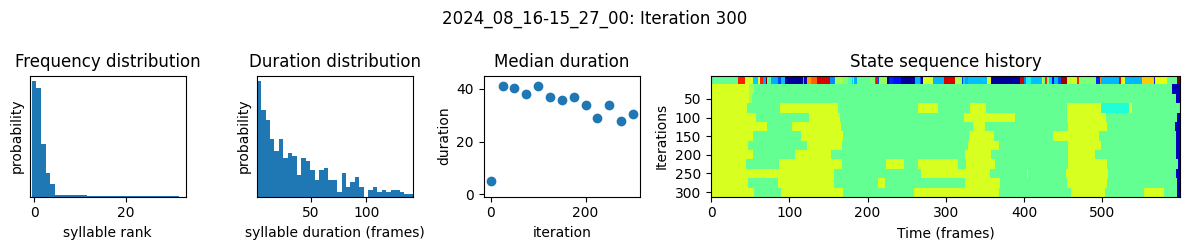

 55%|██████████████████               | 275/501 [02:31<01:32,  2.45it/s]

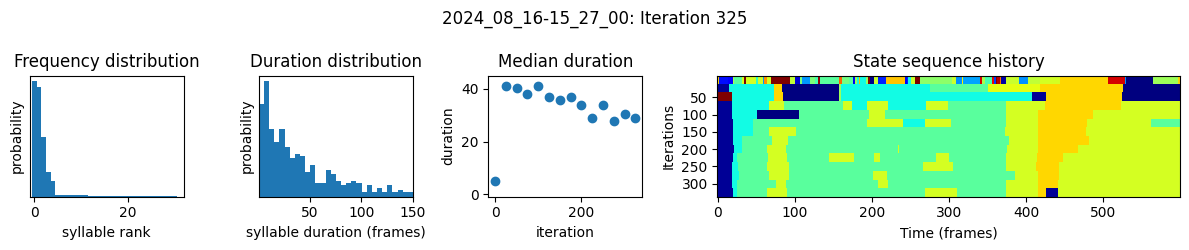

 60%|███████████████████▊             | 300/501 [02:42<01:23,  2.41it/s]

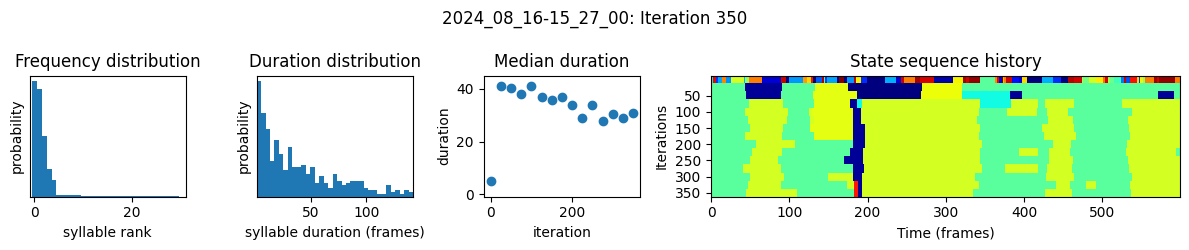

 65%|█████████████████████▍           | 325/501 [02:52<01:15,  2.33it/s]

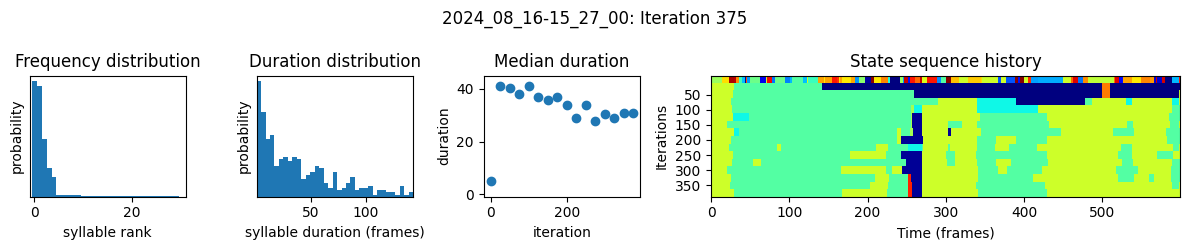

 70%|███████████████████████          | 350/501 [03:03<01:00,  2.48it/s]

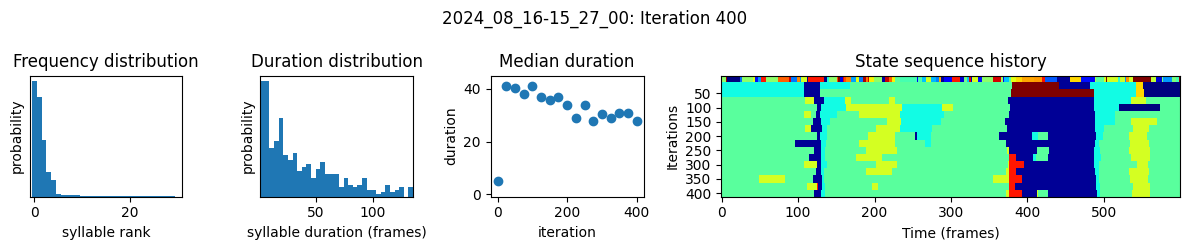

 75%|████████████████████████▋        | 375/501 [03:15<00:56,  2.25it/s]

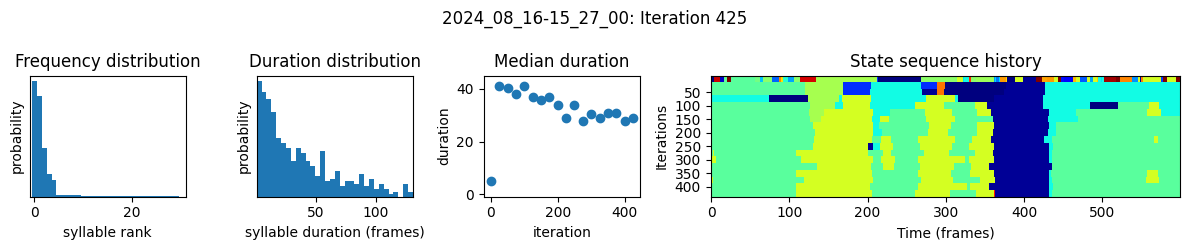

 80%|██████████████████████████▎      | 400/501 [03:25<00:42,  2.38it/s]

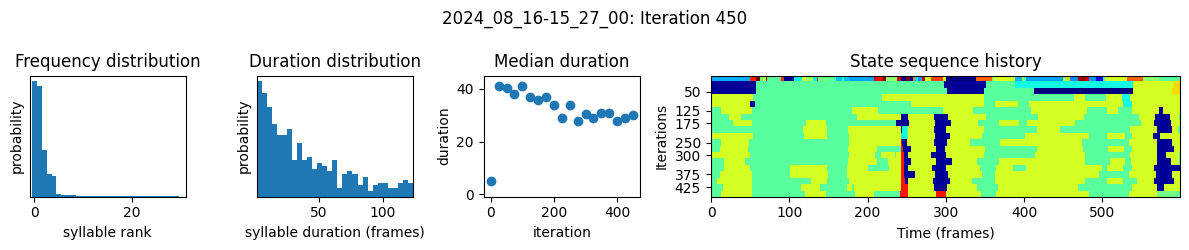

 85%|███████████████████████████▉     | 425/501 [03:36<00:31,  2.39it/s]

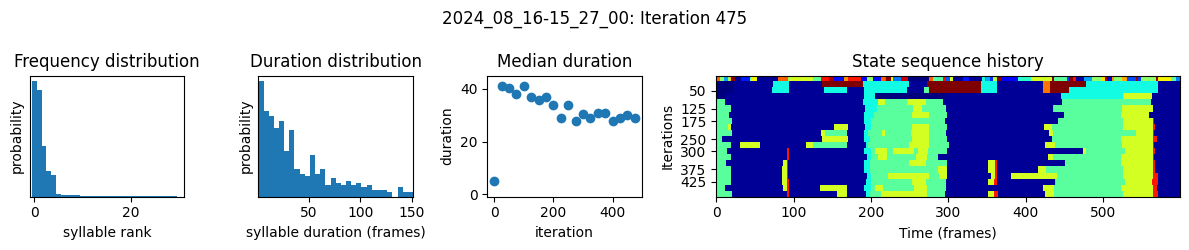

 90%|█████████████████████████████▋   | 450/501 [03:47<00:21,  2.39it/s]

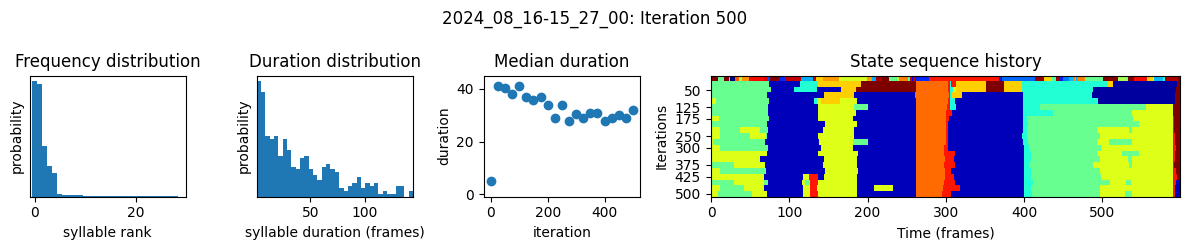

 95%|███████████████████████████████▎ | 475/501 [03:58<00:11,  2.21it/s]

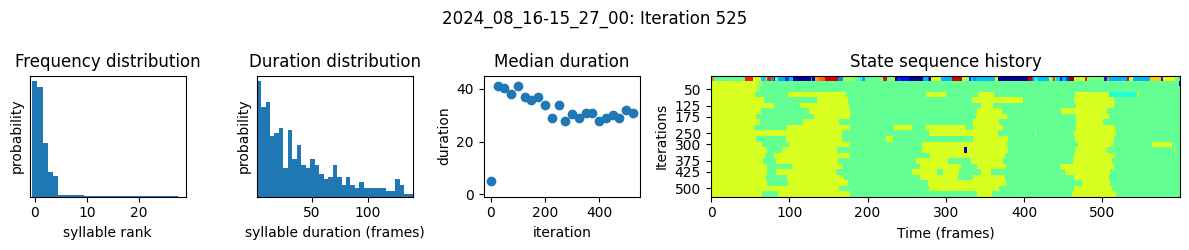

100%|████████████████████████████████▉| 500/501 [04:09<00:00,  2.44it/s]

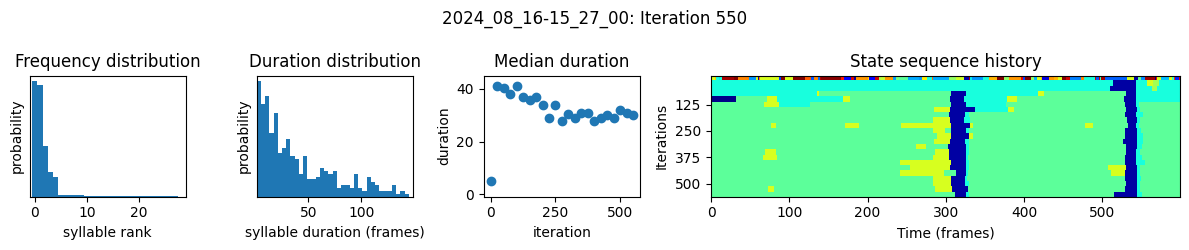

100%|█████████████████████████████████| 501/501 [04:10<00:00,  2.00it/s]


In [22]:
# load model checkpoint
model, data, metadata, current_iter = kpms.load_checkpoint(
    kpms_project_dir, model_name, iteration=num_ar_iters)

# modify kappa to maintain the desired syllable time-scale
model = kpms.update_hypparams(model, kappa=1e4)

# run fitting for an additional 500 iters
model = kpms.fit_model(
    model, data, metadata, kpms_project_dir, model_name, ar_only=False, 
    start_iter=current_iter, num_iters=current_iter+500)[0]
    

In [23]:
# modify a saved checkpoint so syllables are ordered by frequency
kpms.reindex_syllables_in_checkpoint(kpms_project_dir, model_name);

Reindexing: 100%|██████████| 23/23 [00:00<00:00, 109.13model snapshot/s]


In [24]:
# load the most recent model checkpoint
model, data, metadata, current_iter = kpms.load_checkpoint(kpms_project_dir, model_name)

# extract results
results = kpms.extract_results(model, metadata, kpms_project_dir, model_name)

Saved results to /Users/nsirmpilatze/Data/behav-analysis-course/mouse-
EPM/derivatives/behav/software-
kpms_project/2024_08_16-15_27_00/results.h5


In [30]:
kpms.save_results_as_csv(results, kpms_project_dir, model_name)

Saving to csv: 100%|██████████████████████| 1/1 [00:00<00:00, 13.58it/s]


Saving trajectory plots to /Users/nsirmpilatze/Data/behav-analysis-course/mouse-EPM/derivatives/behav/software-kpms_project/2024_08_16-15_27_00/trajectory_plots


Generating trajectory plots: 100%|████████| 3/3 [00:00<00:00,  5.61it/s]


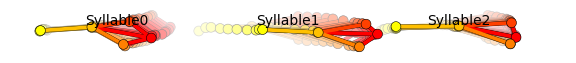

In [29]:
kpms.generate_trajectory_plots(coordinates, results, kpms_project_dir, model_name, **config)

In [27]:
kpms.generate_grid_movies(results, kpms_project_dir, model_name, coordinates=coordinates, **config);

Writing grid movies to /Users/nsirmpilatze/Data/behav-analysis-course/mouse-EPM/derivatives/behav/software-kpms_project/2024_08_16-15_27_00/grid_movies
Using window size of 288 pixels


Generating grid movies: 100%|█████████████| 4/4 [00:45<00:00, 11.30s/it]


In [28]:
kpms.plot_similarity_dendrogram(coordinates, results, kpms_project_dir, model_name, **config)

/Users/nsirmpilatze/.miniconda3/envs/keypoint_moseq/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning:

All-NaN slice encountered



ValueError: Distance matrix 'X' must be symmetric.

In [32]:
kpms.plot_similarity_dendrogram(coordinates, results, kpms_project_dir, model_name, **config)

/Users/nsirmpilatze/.miniconda3/envs/keypoint_moseq/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning:

All-NaN slice encountered



ValueError: Distance matrix 'X' must be symmetric.

In [ ]:
# load the most recent model checkpoint and pca object
# model = kpms.load_checkpoint(project_dir, model_name)[0]

# # load new data (e.g. from deeplabcut)
# new_data = 'path/to/new/data/' # can be a file, a directory, or a list of files
# coordinates, confidences, bodyparts = kpms.load_keypoints(new_data, 'deeplabcut')
# data, metadata = kpms.format_data(coordinates, confidences, **config())

# # apply saved model to new data
# results = kpms.apply_model(model, data, metadata, project_dir, model_name, **config())

# optionally rerun `save_results_as_csv` to export the new results
# kpms.save_results_as_csv(results, project_dir, model_name)